In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import json
import seaborn as sns
from scipy import interp
sns.set(style='whitegrid')
from sklearn.metrics import accuracy_score,recall_score, f1_score
import glob
import os
import pathlib
from multi_center_tools.multi_tools import open_pickle, select_df

import scienceplots

import warnings
warnings.filterwarnings('ignore')

In [2]:
def make_score(df):
    df['score'] =df['Proba']
    df.loc[df['Predicted_label']==0, 'score'] = 1 -df['Proba']
    return df

def get_response_score(location):
    f = open(location)
    result = json.load(f)
    return np.array(result['response'])/4

def make_score_with_fold(df, folds):
    for i in range(folds):
        proba_name = 'Proba_fold%d'%i
        score_name = 'Score_fold%d'%i
        label_name = 'Predicted_label_fold%d'%i
        df[score_name] =df[proba_name]
        df.loc[df[label_name]==0, score_name] = 1 -df[proba_name]
    return df

def get_fpr_tpr(label, score):
    y_true =np.array(label)
    y_score =np.array(score)
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    score = roc_auc_score(y_true, y_score)
    return fpr, tpr, score

### Prepartion dataset

In [3]:
#Load TCGA Result
TCGA_test = pd.read_csv(
    '/programing/python/HvsAI/make_label/make_dataset_for_clinical/data/TCGA_test_sampled_with_predicted.csv')

#Load JC Result
csv_loc = '/programing/python/vit_experiment/label_data/All_japan.csv'

test_list = open_pickle(
    '/programing/python/vit_experiment/label_data/ALL_Japan_test.pickle')
test_list = [int(n) for n in test_list]

df =pd.read_csv(csv_loc)
JC_test= select_df(df,'ID',test_list )

#JC sampled
JC_test_sampled_with_predicted =  pd.read_csv(
    '/programing/python/HvsAI/make_label/make_dataset_for_clinical/data/JC_test_sampled_with_predicted_list3.csv')

cnn_TCGA_predicted = pd.read_csv(
    '/programing/python/HvsAI/Lr_ken/TCGA/Predict/BS32_10folds/normal_list1/data/TCGA_predicted.csv')
cnn_JC_test_predicted = pd.read_csv(
    '/programing/python/HvsAI/Lr_ken/TCGA/Predict/BS32_10folds/normal_list1/data/JC_test_predicted.csv')
cnn_TCGA_merged = pd.merge(TCGA_test, cnn_TCGA_predicted, on='ID')
cnn_JC_test_merged = pd.merge(JC_test, cnn_JC_test_predicted, on='ID')
cnn_JC_test_sampled_merged = pd.merge(JC_test_sampled_with_predicted, cnn_JC_test_predicted, on='ID')

In [4]:
cnn_TCGA_predicted = pd.read_csv(
    '/programing/python/HvsAI/Lr_ken/TCGA/Predict/BS32_10folds/normal_list1_width3/data/TCGA_predicted.csv')
cnn_JC_test_predicted = pd.read_csv(
    '/programing/python/HvsAI/Lr_ken/TCGA/Predict/BS32_10folds/normal_list1_width3/data/JC_test_predicted.csv')
cnn_TCGA_merged = pd.merge(TCGA_test, cnn_TCGA_predicted, on='ID')
cnn_JC_test_merged = pd.merge(JC_test, cnn_JC_test_predicted, on='ID')
cnn_JC_test_sampled_merged = pd.merge(JC_test_sampled_with_predicted, cnn_JC_test_predicted, on='ID')

In [5]:
cnn_JC_test_sampled_merged

,ID,Institute,histological_type,age_at_initial_pathologic_diagnosis,gender,operation,start_day,WHO_grade,LGG_or_GBM,IDH/TERT,...,Predicted_label_fold5,Proba_fold5,Predicted_label_fold6,Proba_fold6,Predicted_label_fold7,Proba_fold7,Predicted_label_fold8,Proba_fold8,Predicted_label_fold9,Proba_fold9
0,9037,YCU,GBM,49,F,GTR,2010/8/10,4.0,GBM,Group C,...,0,0.995505,0,0.774972,1,0.999782,0,0.997510,0,0.770849
1,31061,NCC,DA,31,F,NaN,NaN,2.0,LGG,Group B,...,1,0.999711,1,0.804009,1,0.999968,1,0.986003,1,0.929530
2,31028,NCC,DA,72,F,NaN,NaN,2.0,LGG,Group C,...,0,0.999119,0,0.737349,0,0.998668,0,0.999952,0,0.948673
3,31006,NCC,OL,39,F,NaN,NaN,2.0,LGG,Group A,...,0,0.999033,1,0.649664,1,0.985147,0,0.663089,0,0.822282
4,30048,NCC,GBM,58,F,NaN,NaN,NaN,GBM,Group D,...,0,0.565116,1,0.568384,1,0.999587,0,0.986475,1,0.625730
5,7049,OU,DA,38,F,Biopsy,2013/11/11,2.0,LGG,Group C,...,0,0.790159,1,0.517532,0,0.870874,0,0.942908,0,0.524840
6,7014,OU,DA,42,F,Biopsy,2012/4/26,2.0,LGG,Group C,...,0,0.992222,0,0.926007,0,0.949142,0,0.955480,0,0.995389
7,3025,SMU,DA,21,F,90%,2010/2/12,2.0,LGG,Group B,...,0,0.828482,1,0.568999,1,0.999629,1,0.947112,1,0.587637
8,8068,KNBTG,GBM,70,F,Biopsy,2012/11/30,4.0,GBM,Group D,...,0,0.999659,0,0.960394,1,0.994324,0,0.999993,0,0.916226
9,31036,NCC,DA,33,M,NaN,NaN,2.0,LGG,Group B,...,0,0.999661,0,0.948962,0,0.946053,0,0.993616,0,0.835136


In [6]:
vi_TCGA_predicted = pd.read_csv('/programing/python/vit_experiment/TCGA/predict/BS32_normal_list1/data/TCGA_predicted.csv')
vi_JC_test_predicted = pd.read_csv('/programing/python/vit_experiment/TCGA/predict/BS32_normal_list1/data/JC_test_predicted.csv')
vi_TCGA_merged = pd.merge(TCGA_test, vi_TCGA_predicted, on='ID')
vi_JC_test_merged = pd.merge(JC_test, vi_JC_test_predicted, on='ID')
vi_JC_test_sampled_merged = pd.merge(JC_test_sampled_with_predicted, vi_JC_test_predicted, on='ID')

vi_JC_test_merged.to_csv('../attention_map/data/for_attentionmap.csv')

In [7]:
cnn_TCGA_merged = make_score_with_fold(cnn_TCGA_merged, 10)
cnn_JC_test_merged = make_score_with_fold(cnn_JC_test_merged, 10)
cnn_JC_test_sampled_merged = make_score_with_fold(cnn_JC_test_sampled_merged, 10)

vi_TCGA_merged = make_score_with_fold(vi_TCGA_merged, 10)
vi_JC_test_merged = make_score_with_fold(vi_JC_test_merged, 10)
vi_JC_test_sampled_merged = make_score_with_fold(vi_JC_test_sampled_merged, 10)

In [ ]:
vi_JC_test_sampled_merged

In [9]:
JC_test_true =np.array(JC_test['IDH1_2'])
JC_test_sampled_true =np.array(JC_test_sampled_with_predicted ['IDH1_2'])

TCGA_test_true =np.array(TCGA_test['IDH1_2'])

In [10]:
TCGA_test_true

array([1, 1, 1, 0, 1, 0, 1, 1, 1, 0])

In [11]:
JC_test_true

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0])

In [12]:
JC_test_sampled_true

array([0, 1, 0, 1, 0, 0, 0, 1, 0, 1])

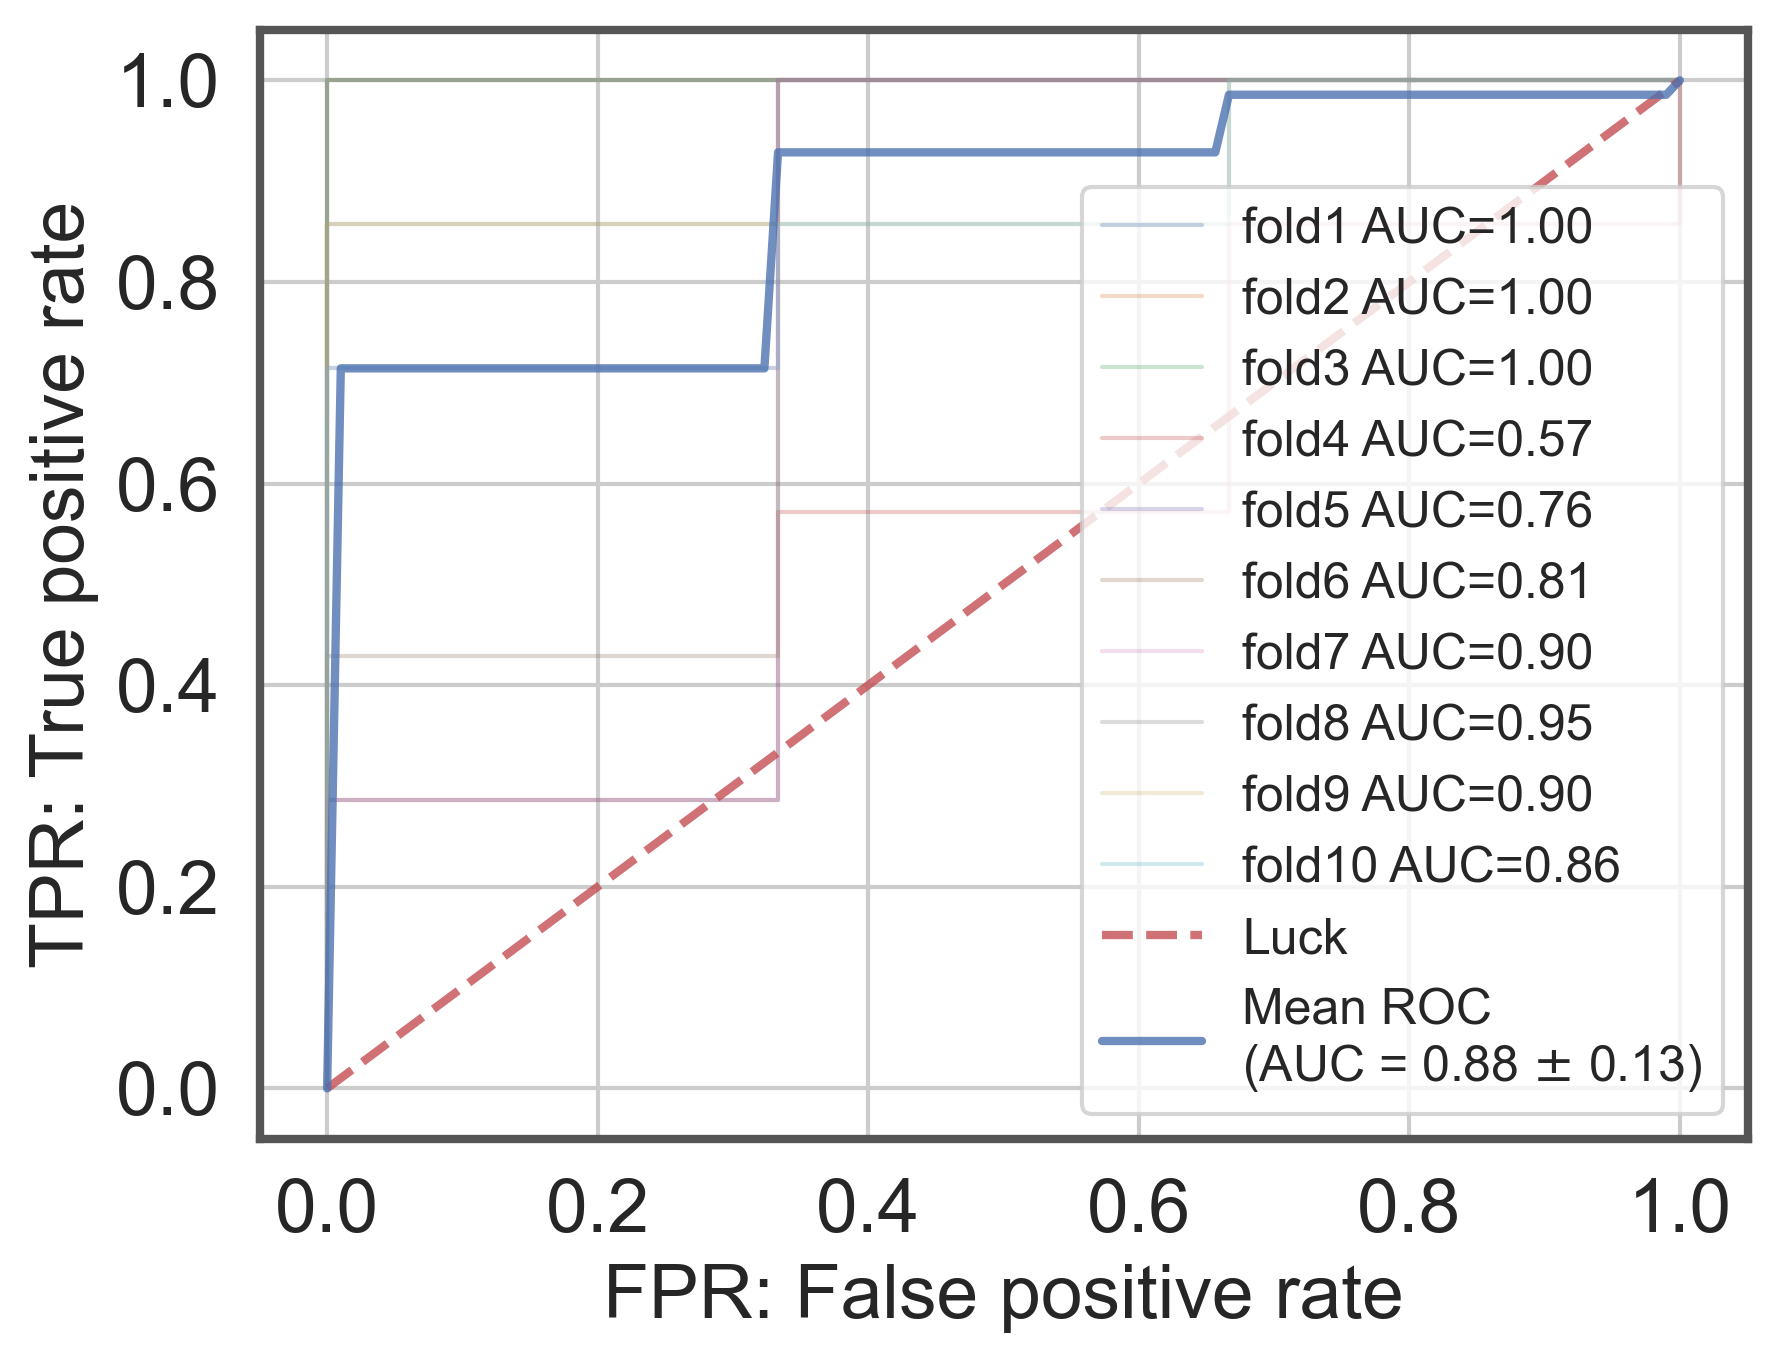

In [28]:
TPRS = []
AUCS = []
mean_fpr = np.linspace(0, 1, 100)
plt.rcParams['font.family']='Arial'
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1,1,1)
plt.rcParams["font.size"] = 30

#set axis color ant thickness
corners = ['top', 'bottom', 'left', 'right']
for corner in corners:
    ax.spines[corner].set_color('#555555')
    ax.spines[corner].set_linewidth(2)


for i in range(10):
    score_name = 'Score_fold%d'%i
    fpr, tpr, score = get_fpr_tpr(TCGA_test_true, cnn_TCGA_merged[score_name])
    ax.plot(fpr, tpr,lw=1, alpha=0.3,label='fold%d AUC=%0.2f'%(i+1, score))
    TPRS.append(interp(mean_fpr, fpr, tpr))
    TPRS[-1][0] = 0.0
    AUCS.append(score)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Luck', alpha=.8)
    
cnn_TCGA_mean_tpr = np.mean(TPRS, axis=0)
cnn_TCGA_mean_tpr[-1] = 1.0
cnn_TCGA_mean_auc = np.array(AUCS).mean()
cnn_TCGA_std_auc = np.std(AUCS)

ax.plot(mean_fpr, cnn_TCGA_mean_tpr, color='b',
             label=r'Mean ROC'+"\n"+'(AUC = %0.2f $\pm$ %0.2f)' % (cnn_TCGA_mean_auc, cnn_TCGA_std_auc),
             lw=2, alpha=.8)

#ax.xlim([-0.05, 1.05])
#ax.ylim([-0.05, 1.05])
ax.tick_params(labelsize=18)
ax.legend(fontsize =12)
ax.set_xlabel('FPR: False positive rate',fontsize=18)
ax.set_ylabel('TPR: True positive rate',fontsize=18)

cnn_TCGA_aucs = AUCS

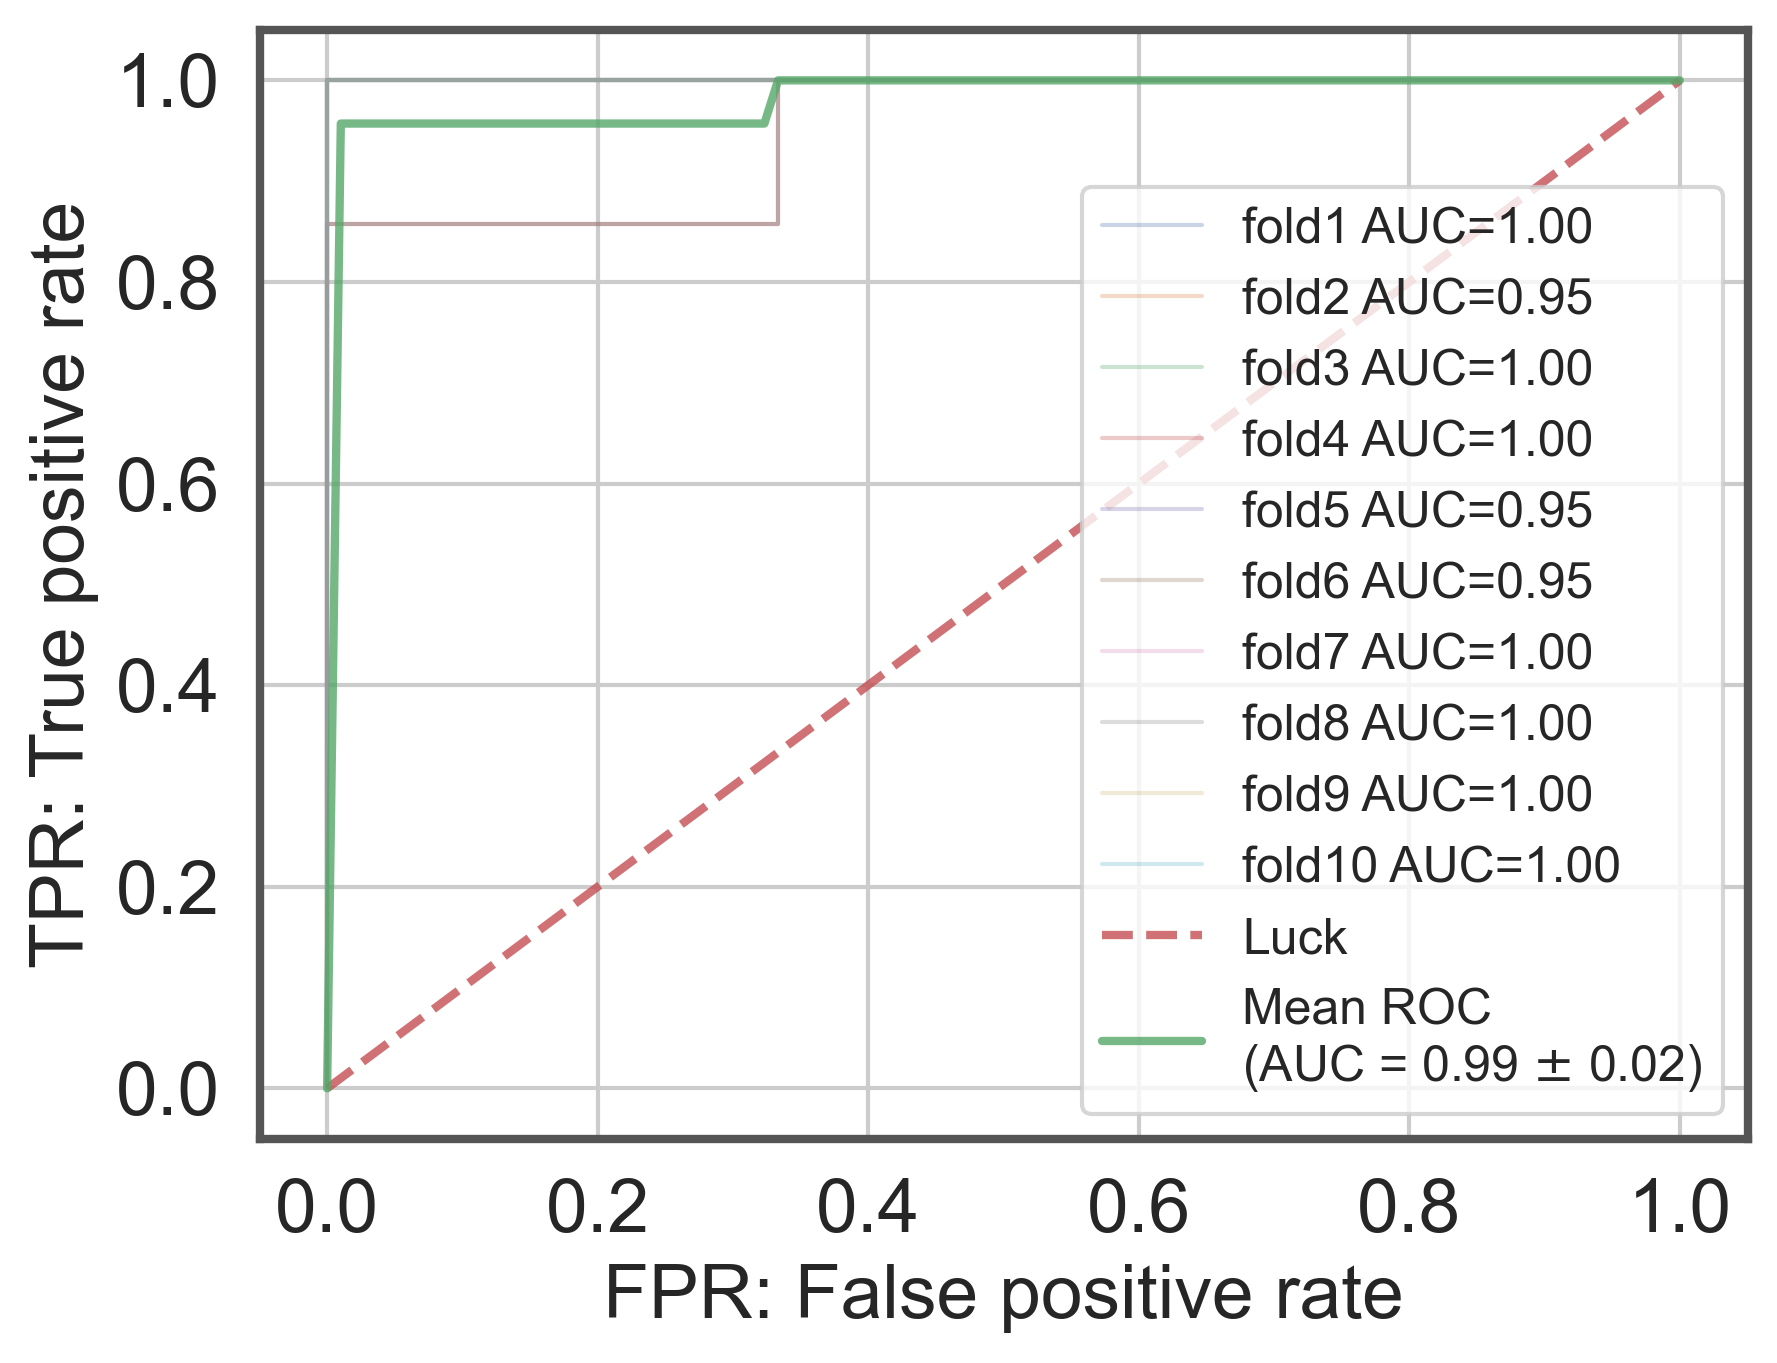

In [29]:
TPRS = []
AUCS = []
mean_fpr = np.linspace(0, 1, 100)
plt.rcParams['font.family']='Arial'
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1,1,1)
plt.rcParams["font.size"] = 30

#set axis color ant thickness
corners = ['top', 'bottom', 'left', 'right']
for corner in corners:
    ax.spines[corner].set_color('#555555')
    ax.spines[corner].set_linewidth(2)

for i in range(10):
    score_name = 'Score_fold%d'%i
    fpr, tpr, score = get_fpr_tpr(TCGA_test_true, vi_TCGA_merged[score_name])
    ax.plot(fpr, tpr,lw=1, alpha=0.3,label='fold%d AUC=%0.2f'%(i+1, score))
    TPRS.append(interp(mean_fpr, fpr, tpr))
    TPRS[-1][0] = 0.0
    AUCS.append(score)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Luck', alpha=.8)
    
vi_TCGA_mean_tpr = np.mean(TPRS, axis=0)
vi_TCGA_mean_tpr[-1] = 1.0
vi_TCGA_mean_auc = np.array(AUCS).mean()
vi_TCGA_std_auc = np.std(AUCS)
ax.plot(mean_fpr, vi_TCGA_mean_tpr, color='g',
             label=r'Mean ROC'+"\n"+'(AUC = %0.2f $\pm$ %0.2f)' % (vi_TCGA_mean_auc, vi_TCGA_std_auc),
             lw=2, alpha=.8)

#ax.xlim([-0.05, 1.05])
#ax.ylim([-0.05, 1.05])
ax.tick_params(labelsize=18)
ax.legend(fontsize =12)
ax.set_xlabel('FPR: False positive rate',fontsize=18)
ax.set_ylabel('TPR: True positive rate',fontsize=18)

vit_TCGA_aucs = AUCS

Text(0, 0.5, 'TPR: True positive rate')

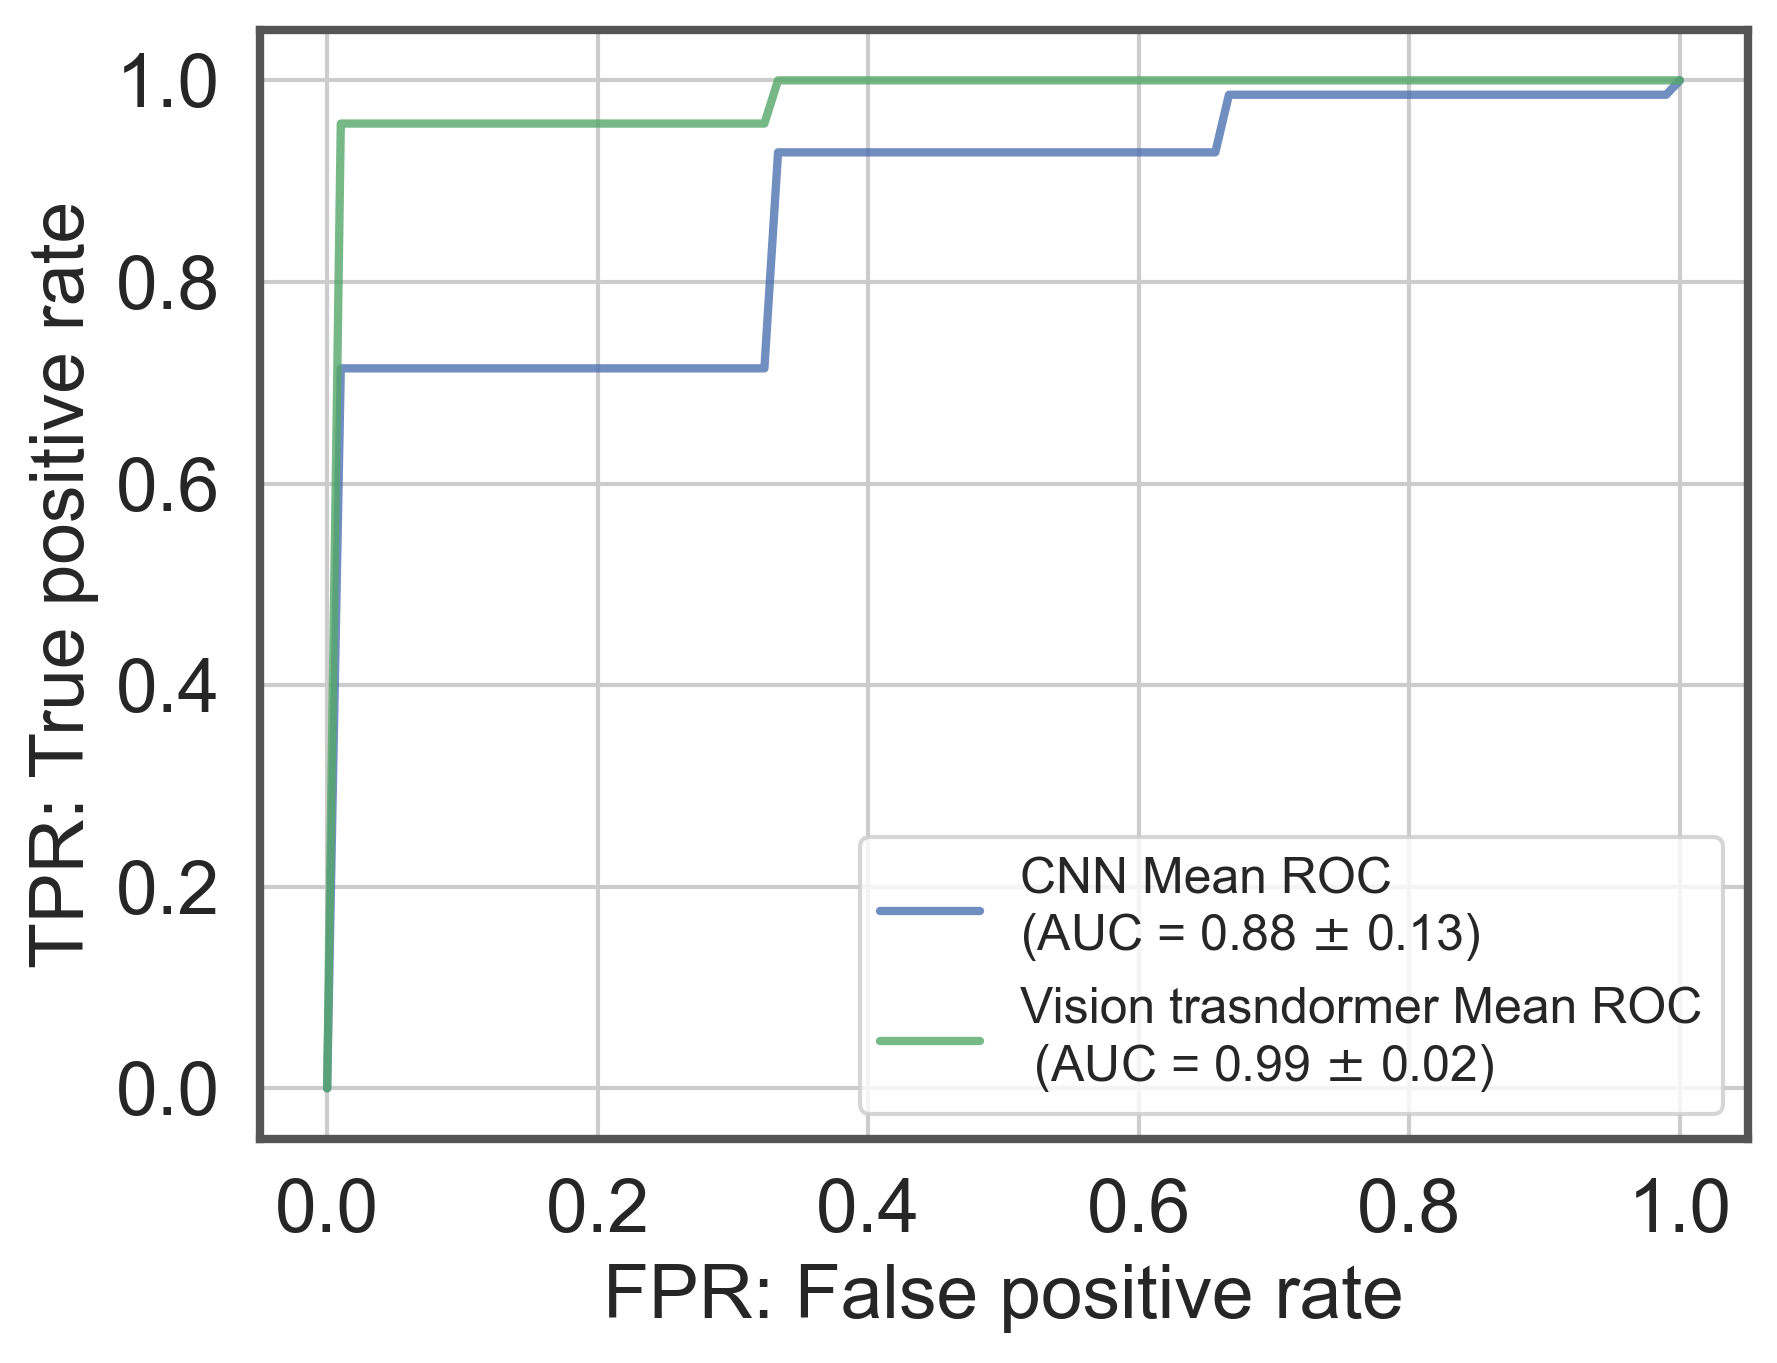

In [30]:
mean_fpr = np.linspace(0, 1, 100)
mean_fpr = np.linspace(0, 1, 100)
plt.rcParams['font.family']='Arial'
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1,1,1)
plt.rcParams["font.size"] = 30

#set axis color ant thickness
corners = ['top', 'bottom', 'left', 'right']
for corner in corners:
    ax.spines[corner].set_color('#555555')
    ax.spines[corner].set_linewidth(2)


ax.plot(mean_fpr, cnn_TCGA_mean_tpr, color='b',
             label=r'CNN Mean ROC '+"\n"+'(AUC = %0.2f $\pm$ %0.2f)' % (cnn_TCGA_mean_auc, cnn_TCGA_std_auc),
             lw=2, alpha=.8)
ax.plot(mean_fpr, vi_TCGA_mean_tpr, color='g',
             label=r'Vision trasndormer Mean ROC'+"\n"+' (AUC = %0.2f $\pm$ %0.2f)' % (vi_TCGA_mean_auc, vi_TCGA_std_auc),
             lw=2, alpha=.8)
#ax.xlim([-0.05, 1.05])
#ax.ylim([-0.05, 1.05])
ax.tick_params(labelsize=18)
ax.legend(fontsize =12)
ax.set_xlabel('FPR: False positive rate',fontsize=18)
ax.set_ylabel('TPR: True positive rate',fontsize=18)

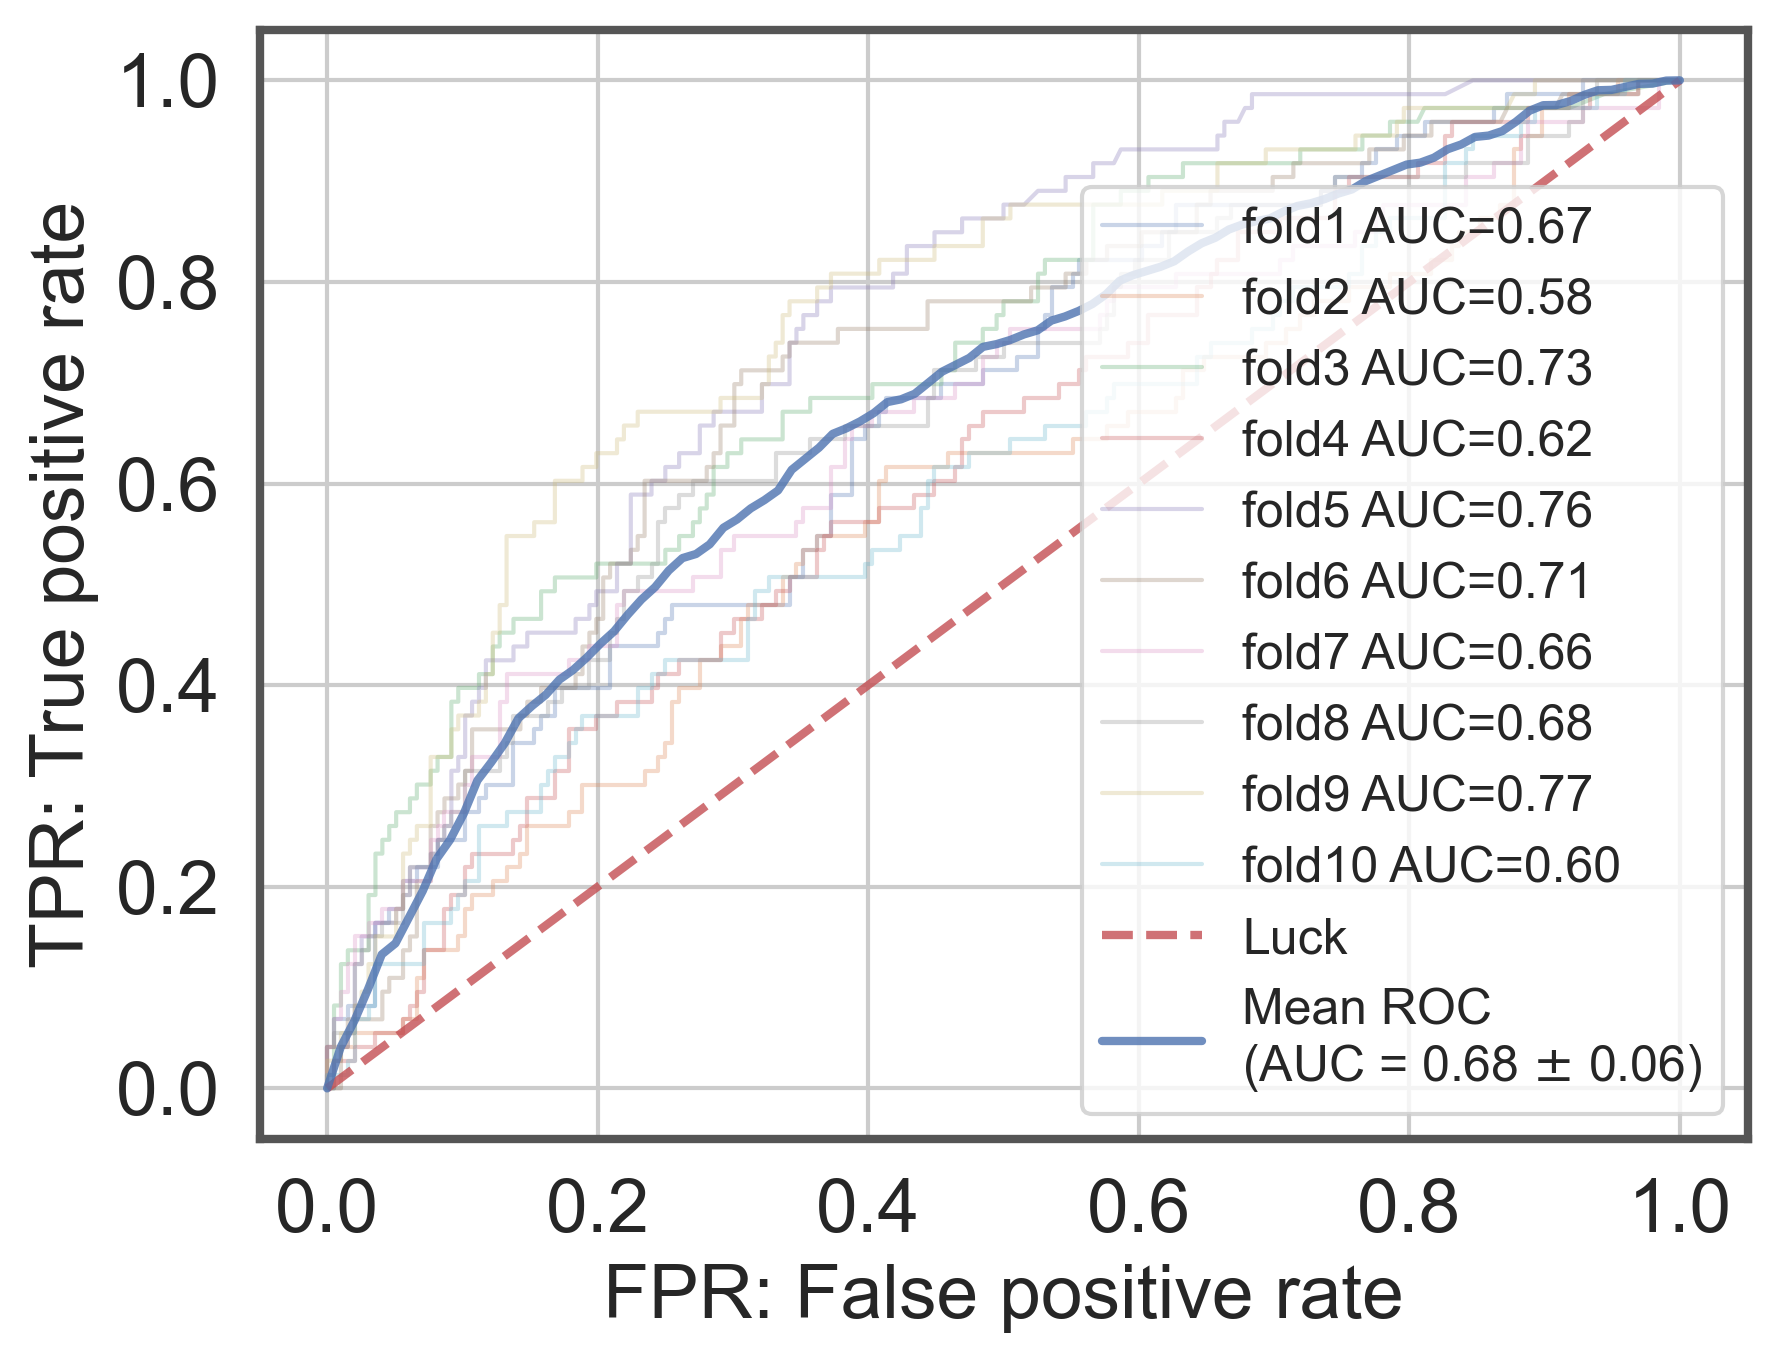

In [31]:
TPRS = []
AUCS = []
mean_fpr = np.linspace(0, 1, 100)
plt.rcParams['font.family']='Arial'
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1,1,1)
plt.rcParams["font.size"] = 30

#set axis color ant thickness
corners = ['top', 'bottom', 'left', 'right']
for corner in corners:
    ax.spines[corner].set_color('#555555')
    ax.spines[corner].set_linewidth(2)

for i in range(10):
    score_name = 'Score_fold%d'%i
    fpr, tpr, score = get_fpr_tpr(JC_test_true, cnn_JC_test_merged[score_name])
    ax.plot(fpr, tpr,lw=1, alpha=0.3,label='fold%d AUC=%0.2f'%(i+1, score))
    TPRS.append(interp(mean_fpr, fpr, tpr))
    TPRS[-1][0] = 0.0
    AUCS.append(score)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Luck', alpha=.8)
    
cnn_JC_mean_tpr = np.mean(TPRS, axis=0)
cnn_JC_mean_tpr[-1] = 1.0
cnn_JC_mean_auc = np.array(AUCS).mean()
cnn_JC_std_auc = np.std(AUCS)
ax.plot(mean_fpr, cnn_JC_mean_tpr, color='b',
             label=r'Mean ROC'+"\n"+'(AUC = %0.2f $\pm$ %0.2f)' % (cnn_JC_mean_auc, cnn_JC_std_auc),
             lw=2, alpha=.8)

#ax.xlim([-0.05, 1.05])
#ax.ylim([-0.05, 1.05])
ax.tick_params(labelsize=18)
ax.legend(fontsize =12)
ax.set_xlabel('FPR: False positive rate',fontsize=18)
ax.set_ylabel('TPR: True positive rate',fontsize=18)

cnn_JC_aucs = AUCS

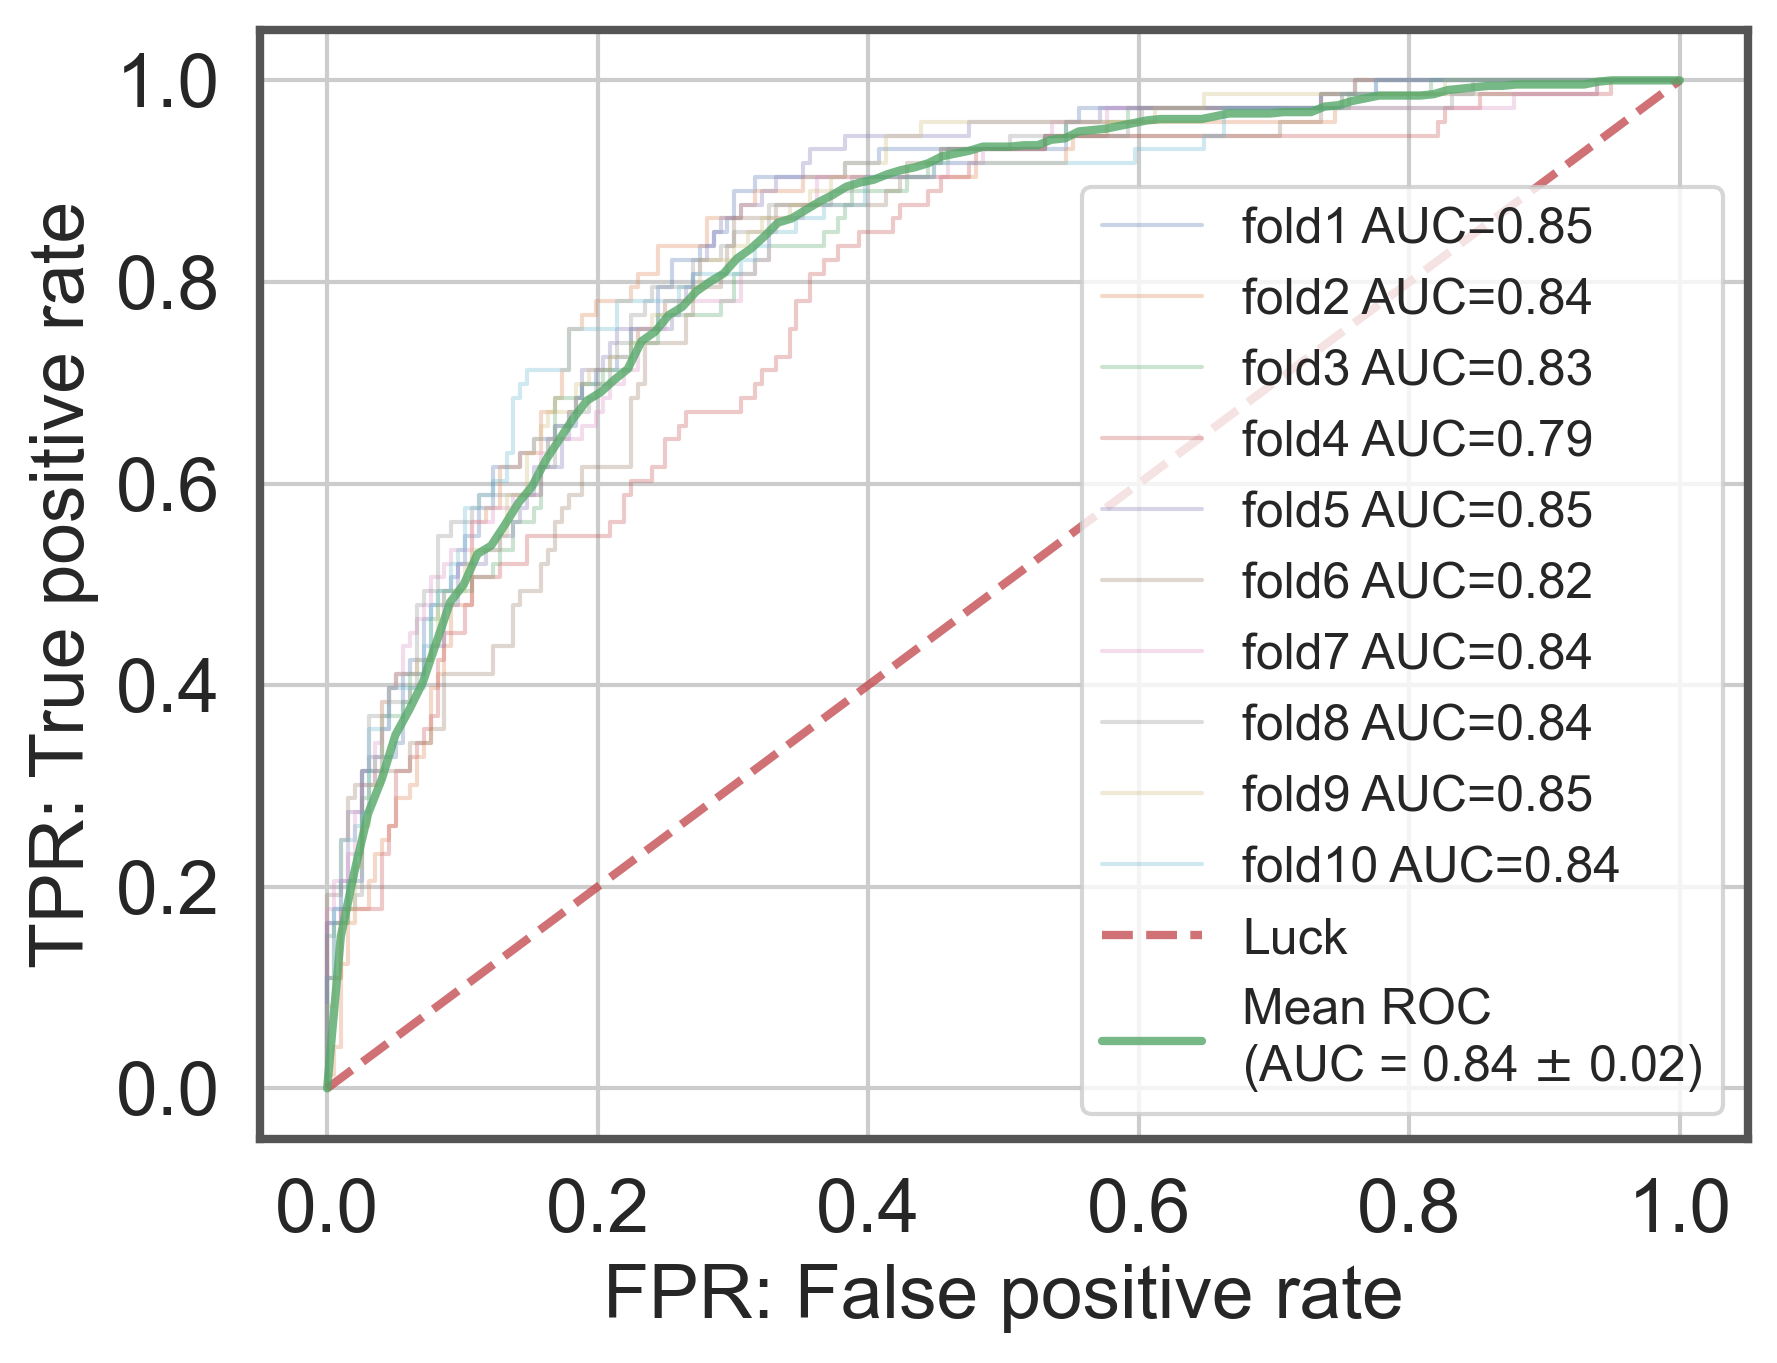

In [32]:
TPRS = []
AUCS = []
mean_fpr = np.linspace(0, 1, 100)
plt.rcParams['font.family']='Arial'
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1,1,1)
plt.rcParams["font.size"] = 30

#set axis color ant thickness
corners = ['top', 'bottom', 'left', 'right']
for corner in corners:
    ax.spines[corner].set_color('#555555')
    ax.spines[corner].set_linewidth(2)


for i in range(10):
    score_name = 'Score_fold%d'%i
    fpr, tpr, score = get_fpr_tpr(JC_test_true, vi_JC_test_merged[score_name])
    ax.plot(fpr, tpr,lw=1, alpha=0.3,label='fold%d AUC=%0.2f'%(i+1, score))
    TPRS.append(interp(mean_fpr, fpr, tpr))
    TPRS[-1][0] = 0.0
    AUCS.append(score)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Luck', alpha=.8)
    
vi_JC_mean_tpr = np.mean(TPRS, axis=0)
vi_JC_mean_tpr[-1] = 1.0
vi_JC_mean_auc = np.array(AUCS).mean()
vi_JC_std_auc = np.std(AUCS)
ax.plot(mean_fpr, vi_JC_mean_tpr, color='g',
             label=r'Mean ROC'+"\n"+'(AUC = %0.2f $\pm$ %0.2f)' % (vi_JC_mean_auc, vi_JC_std_auc),
             lw=2, alpha=.8)

#ax.xlim([-0.05, 1.05])
#ax.ylim([-0.05, 1.05])
ax.tick_params(labelsize=18)
ax.legend(fontsize =12)
ax.set_xlabel('FPR: False positive rate',fontsize=18)
ax.set_ylabel('TPR: True positive rate',fontsize=18)

vit_JC_aucs = AUCS

Text(0, 0.5, 'TPR: True positive rate')

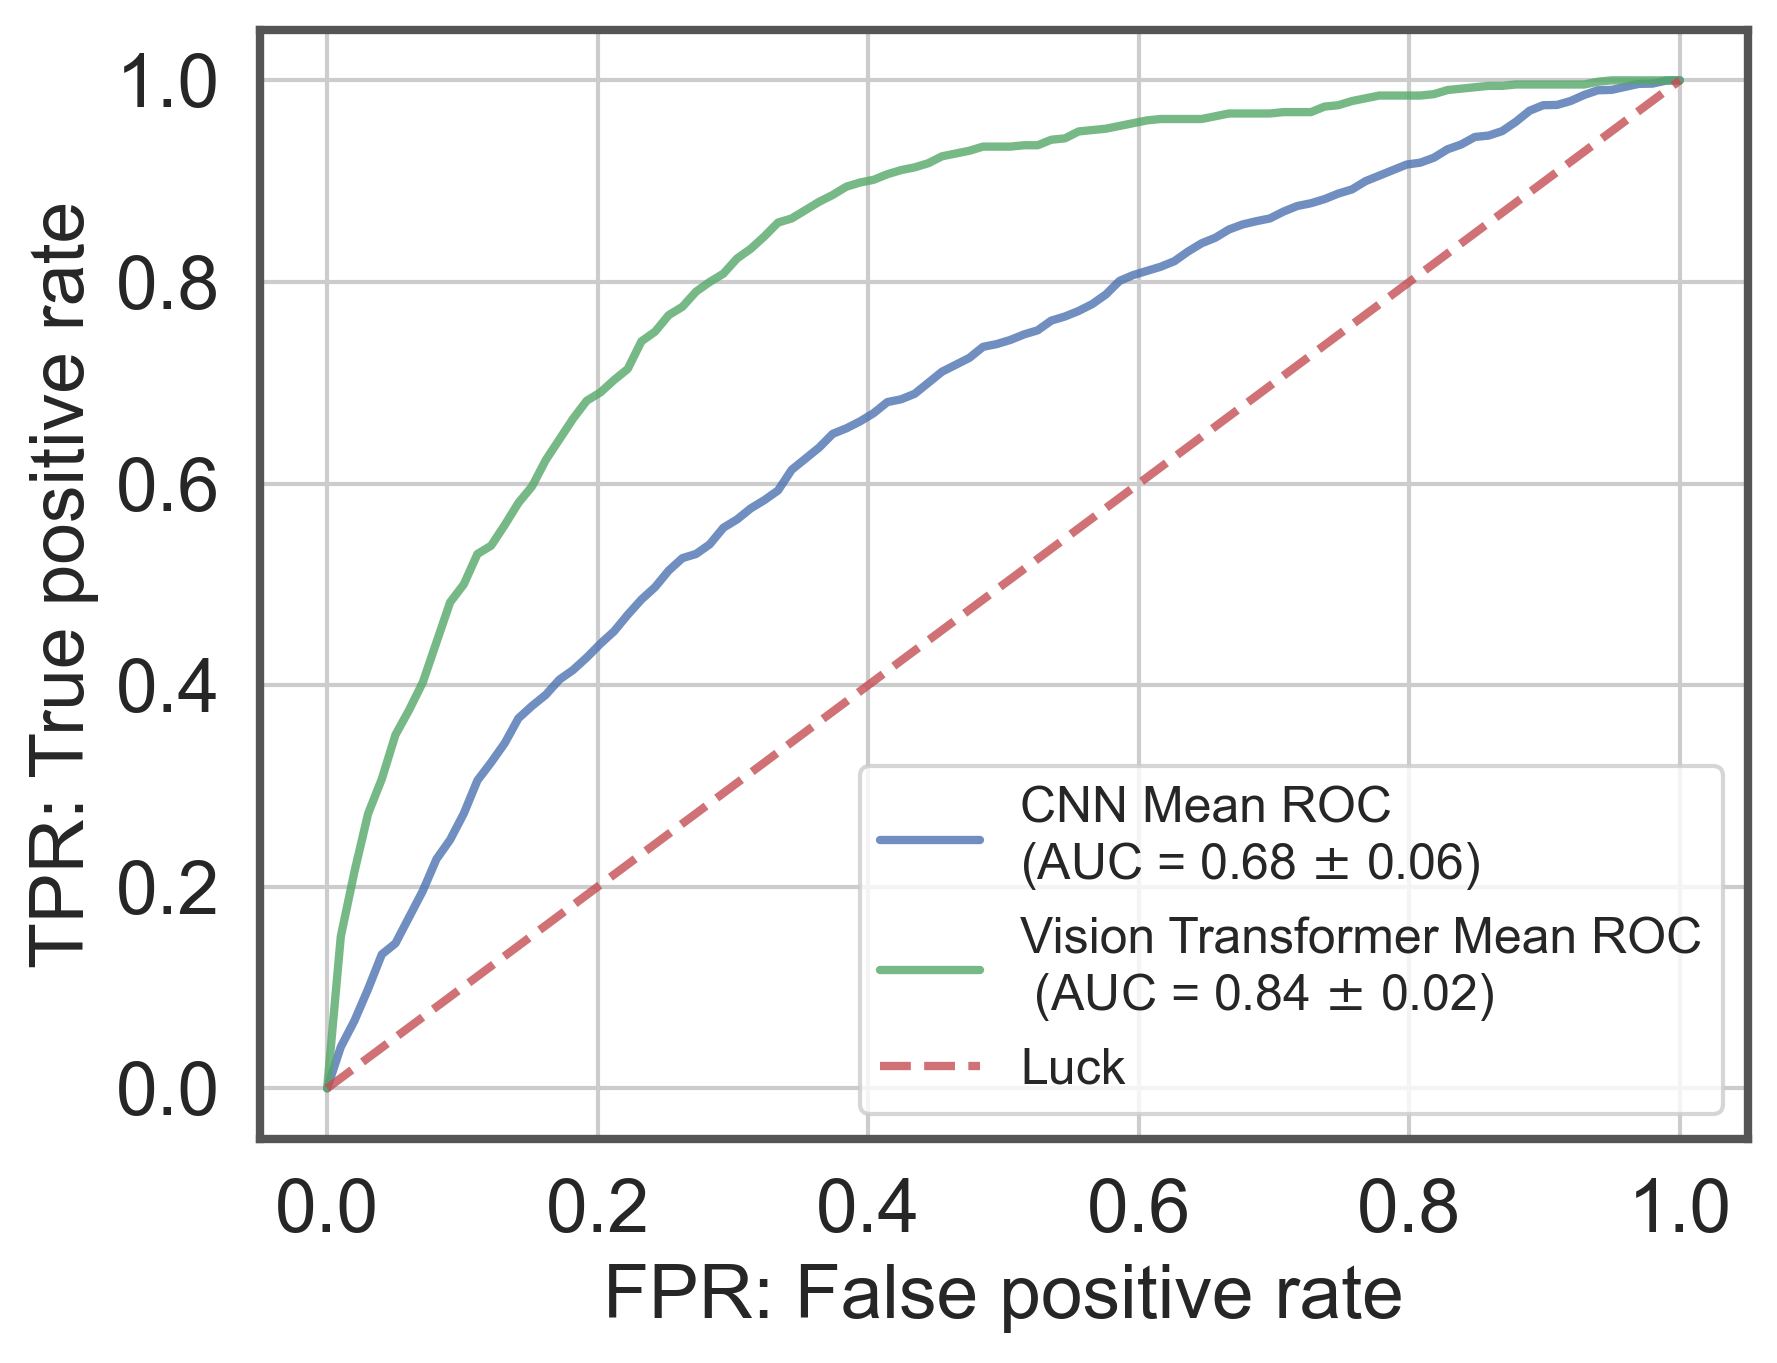

In [33]:
mean_fpr = np.linspace(0, 1, 100)
plt.rcParams['font.family']='Arial'
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1,1,1)
plt.rcParams["font.size"] = 30

#set axis color ant thickness
corners = ['top', 'bottom', 'left', 'right']
for corner in corners:
    ax.spines[corner].set_color('#555555')
    ax.spines[corner].set_linewidth(2)

ax.plot(mean_fpr, cnn_JC_mean_tpr, color='b',
             label=r'CNN Mean ROC '+"\n"+'(AUC = %0.2f $\pm$ %0.2f)' % (cnn_JC_mean_auc, cnn_JC_std_auc),
             lw=2, alpha=.8)

ax.plot(mean_fpr, vi_JC_mean_tpr, color='g',
             label=r'Vision Transformer Mean ROC'+"\n"+' (AUC = %0.2f $\pm$ %0.2f)' % (vi_JC_mean_auc, vi_JC_std_auc),
             lw=2, alpha=.8)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Luck', alpha=.8)
ax.tick_params(labelsize=18)
ax.legend(fontsize =12)
ax.set_xlabel('FPR: False positive rate',fontsize=18)
ax.set_ylabel('TPR: True positive rate',fontsize=18)

In [50]:
import scipy
scipy.stats.mannwhitneyu(cnn_TCGA_aucs, vit_TCGA_aucs)

MannwhitneyuResult(statistic=21.0, pvalue=0.0207856540232793)

In [51]:
import scipy
scipy.stats.mannwhitneyu(cnn_JC_aucs, vit_JC_aucs)

MannwhitneyuResult(statistic=0.0, pvalue=0.0001816511460914649)